In [48]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import string
import os
import glob
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib

## LABDOS flights

In [78]:
#PRG-WAW
fto = '/storage/experiments/2023/04_HIMAC/PRG_WAW'
SWITCH_ON_TIMES = ['2023-04-22 7:45']

#WAW-NRT
fto = '/storage/experiments/2023/04_HIMAC/WAW_NRT'
SWITCH_ON_TIMES = ['2023-04-22 13:15']


## Load and plot data from LABDOS

In [133]:
print (fto)

ID = '/LABDOS_EF'
#ID = '/LABDOS_D9'
#ID = '/LABDOS_B8'
#ID = '/LABDOS_20'
#ID = '/LABDOS_8B'
#ID = '/LABDOS_4E'
#ID = '/LABDOS_7E'

l=[]
l.extend(range(0,505))

df = pd.read_csv(fto+ID+'/0.TXT', sep=',', header=None, names=l, comment='*', low_memory=False)
df = df.reset_index(drop=True)
print('Loaded')

/storage/experiments/2023/04_HIMAC/WAW_NRT
Loaded


In [134]:
#SWITCH_ON_TIMES = ['2021-9-18 12:00', '2021-9-19 12:00', '2021-9-20 12:00', '2021-9-21 12:00', '2021-9-22 12:00', '2021-9-23 12:00', '2021-9-24 12:00', '2021-9-25 12:00', '2021-9-26 12:00', '2021-9-27 12:00', '2021-9-28 12:00', '2021-9-29 12:00', '2021-9-30 12:00']
#SWITCH_ON_TIMES = ['2023-03-12 18:09']

df[2] = df[2].apply(pd.to_numeric, errors='coerce')

df['runtime'] = np.nan
df.loc[df[0]=='$HIST','seconds'] = df.loc[df[0]=='$HIST',2]
df.loc[df[0]=='$DOS','seconds'] = 0
df['runtime'] = df['seconds'].diff() * -1
rc = df.copy()
#rc = df.iloc[366870:378082,:].copy()
#rc = df.iloc[366683:378082,:].copy()
#rc = df.iloc[366714:378084,:].copy() 

run = 0
rc['run'] = np.nan

try:
    for x in rc.loc[rc[0]=='$DOS'].index:
        rc.loc[x,'run'] = SWITCH_ON_TIMES[run]
        run += 1
except:
    pass
rc['run'].fillna(method="ffill", inplace=True)

pd.set_option('display.max_rows', rc.shape[0]+1)
print(rc.loc[rc[0]=='$DOS'][[0,1,2,3,4,5,6, 'run', 'runtime']])
#print(rc.loc[rc[0]=='$AIRDOS'][[0,1, 'runtime']])
pd.set_option('display.max_rows', 10)

rc[2] = pd.to_numeric(rc[2])
rc['time'] = pd.to_datetime(rc.run) + pd.to_timedelta(rc[2], unit='s')
rc.set_index(rc['time'], drop=False, inplace=True)

        0          1   2    3                                         4  \
0    $DOS  LABDOS01A NaN  514  71cdf196883fa3ab648ae47327ef2137eb69420f   
3    $DOS  LABDOS01A NaN  514  71cdf196883fa3ab648ae47327ef2137eb69420f   
7    $DOS  LABDOS01A NaN  514  71cdf196883fa3ab648ae47327ef2137eb69420f   
410  $DOS  LABDOS01A NaN  514  71cdf196883fa3ab648ae47327ef2137eb69420f   

           5                                 6               run  runtime  
0    CIBuild  1290c00806a200903c49a000a00000ef  2023-04-22 13:15      NaN  
3    CIBuild  1290c00806a200903c49a000a00000ef  2023-04-22 13:15    22.26  
7    CIBuild  1290c00806a200903c49a000a00000ef  2023-04-22 13:15    33.47  
410  CIBuild  1290c00806a200903c49a000a00000ef  2023-04-22 13:15  4406.40  


# Load and plot telemetry data

In [97]:
#ftt = glob.iglob(fto+"/*/*.csv") # generator, search immediate subdirectories 
ftt = glob.iglob(fto+"/*.csv") # generator, search immediate subdirectories 
tele = pd.DataFrame()
for f in ftt:
    print(f)
    tele = pd.concat([tele, pd.read_csv(f)])
#tele

/storage/experiments/2023/04_HIMAC/WAW_NRT/LO1079_2fffa450.csv


Text(0, 0.5, 'Altitude a.s.l. [ft]')

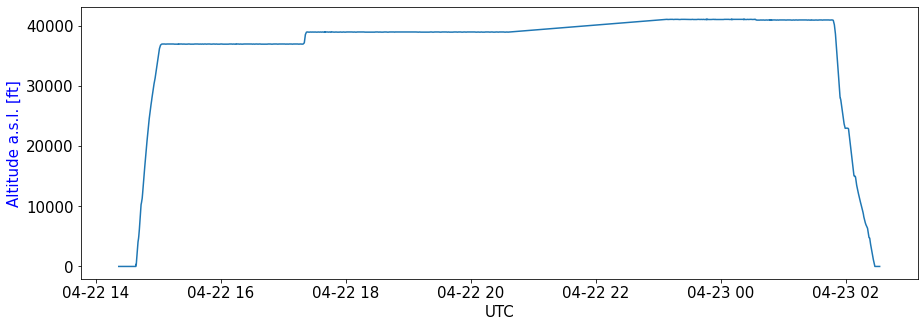

In [98]:
plt.figure(figsize=(15,5))

tele['time'] = pd.to_datetime(tele['UTC'], format='%Y-%m-%dT%H:%M:%SZ')
tele.set_index('time', inplace=True)
tele.sort_index(inplace=True)
plt.plot(tele['Altitude'])
plt.xlabel('UTC')
plt.ylabel('Altitude a.s.l. [ft]', color='blue')

In [121]:
#tele

# Combine AIRDOS and telemetry data

Text(0.5, 1.0, '/storage/experiments/2023/04_HIMAC/WAW_NRT')

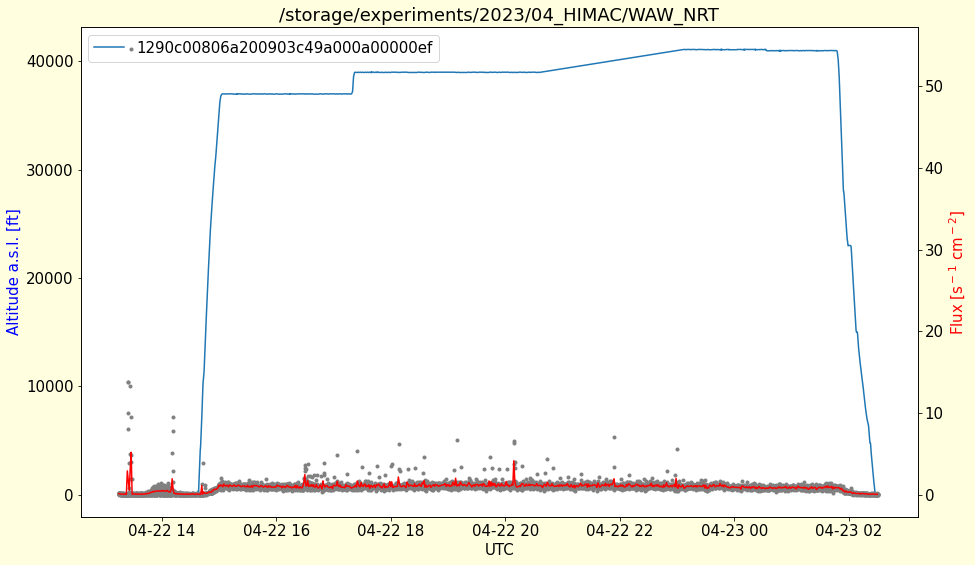

In [122]:
FIRST_CHANNEL = 9

plt.figure(figsize=(15,10), facecolor='lightyellow')
matplotlib.rcParams.update({'font.size': 15})


plt.plot(tele['Altitude'], label=str(rc.loc[rc[0]=='$DOS'][[6]].iloc[0,0]))
# Set limits of plot for magnification
#plt.xlim(pd.Timestamp('2019-09-03'),pd.Timestamp('2019-09-7'))
#plt.xlim(pd.Timestamp('2021-06-8'),pd.Timestamp('2021-06-12'))
#plt.xlim(pd.Timestamp('2021-10-8'),pd.Timestamp('2021-11-5')) # SWA last measurement
#plt.xlim(pd.Timestamp('2021-9-15'),pd.Timestamp('2021-9-28')) # SWB last measurement
plt.ylabel('Altitude a.s.l. [ft]', color='blue')
plt.xlabel('UTC')
plt.legend()
#rc = rc.iloc[3286:]

plt.twinx()

rc['sum'] = rc[range(FIRST_CHANNEL,500)].sum(axis=1)/10/2
#rc['sum'] = rc[range(FIRST_CHANNEL,500)].sum(axis=1)

rc['sum'].plot(marker='.', linestyle='', color='gray')
rcc = rc.resample('1T').mean()
rcc['sum'].plot(color='red')
plt.ylabel('Flux [s$^-$$^1$ cm$^-$$^2$]', color='red')
plt.title(fto)

#plt.ylim([0,1.6]) 


In [120]:
rc

,0,1,2,3,4,5,6,7,8,9,...,500,501,502,503,504,runtime,seconds,run,time,sum
time,,,,,,,,,,,,,,,,,,,,,
NaT,$DOS,LABDOS01A,NaN,514,71cdf196883fa3ab648ae47327ef2137eb69420f,CIBuild,1290c00806a200903c49a000a00000ef,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.00,2023-04-22 13:15,NaT,0.00
2023-04-22 13:15:11.340,$HIST,0,11.34,21355,2,375,17877,6467.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-11.34,11.34,2023-04-22 13:15,2023-04-22 13:15:11.340,0.10
2023-04-22 13:15:22.260,$HIST,1,22.26,21334,5,392,17828,6510.0,14.0,2.0,...,0.0,0.0,0.0,0.0,0.0,-10.92,22.26,2023-04-22 13:15,2023-04-22 13:15:22.260,0.25
NaT,$DOS,LABDOS01A,NaN,514,71cdf196883fa3ab648ae47327ef2137eb69420f,CIBuild,1290c00806a200903c49a000a00000ef,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,22.26,0.00,2023-04-22 13:15,NaT,0.00
2023-04-22 13:15:11.330,$HIST,0,11.33,21443,1,304,18255,6077.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-11.33,11.33,2023-04-22 13:15,2023-04-22 13:15:11.330,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-23 02:29:55.610,$HIST,4376,47695.61,21299,1,221,17668,6888.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-10.82,47695.61,2023-04-22 13:15,2023-04-23 02:29:55.610,0.05
2023-04-23 02:30:06.430,$HIST,4377,47706.43,21402,0,223,17778,6678.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-10.82,47706.43,2023-04-22 13:15,2023-04-23 02:30:06.430,0.00
2023-04-23 02:30:17.240,$HIST,4378,47717.24,21371,2,188,17649,6866.0,7.0,2.0,...,0.0,0.0,0.0,0.0,0.0,-10.81,47717.24,2023-04-22 13:15,2023-04-23 02:30:17.240,0.10


0.034 0.016


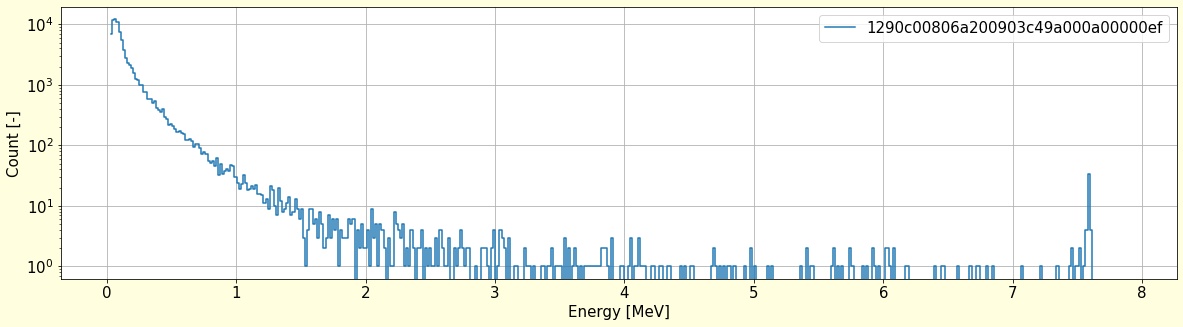

In [148]:
ener = rc.iloc[:,FIRST_CHANNEL:500].sum()

coef3 = np.array([0.,0.])
coef3[1] = 0.016
coef3[0] = 0.034
#coef3[1] = 0.03
#coef3[0] = 0.06

#(60 keV +-15 keV) + CH * 30 keV 
#0.034 MeV + ch * 0.016 MeV


print (coef3[0], coef3[1])

e3 = pd.DataFrame()
e3['1'] = ener
e3['i'] = ener.index
e3['x'] = (e3['i'].astype(float)-FIRST_CHANNEL) * coef3[1] + coef3[0]

plt.figure(figsize=(20,5), facecolor='lightyellow')
matplotlib.rcParams.update({'font.size': 15})
plt.yscale('log')
#plt.xscale('log')

plt.plot(e3['x'], e3['1'] , label=str(rc.loc[rc[0]=='$DOS'][[6]].iloc[0,0]), drawstyle='steps-mid')

plt.xlabel('Energy [MeV]')
plt.ylabel('Count [-]')
plt.grid()
plt.legend()
#plt.xticks(np.arange(0, 10, 1))
#plt.xlim(0,2)
#plt.vlines(0.511,1,1e4, color='red')

None

0.034 0.016


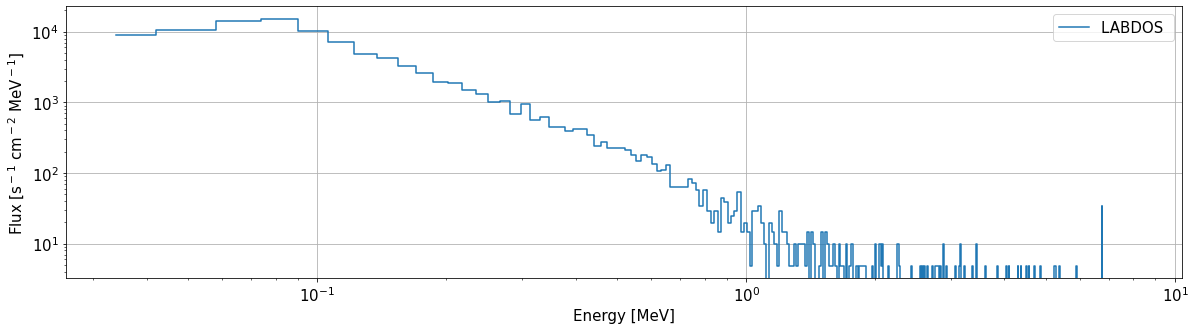

In [12]:
rc.iloc[:,8:500]
#e3.loc[8:499]
e3

,1,i,x
8,1838.0,8,0.034
9,2198.0,9,0.050
10,2949.0,10,0.066
11,3155.0,11,0.082
12,2125.0,12,0.098
...,...,...,...
495,0.0,495,7.826
496,0.0,496,7.842
497,0.0,497,7.858
498,0.0,498,7.874


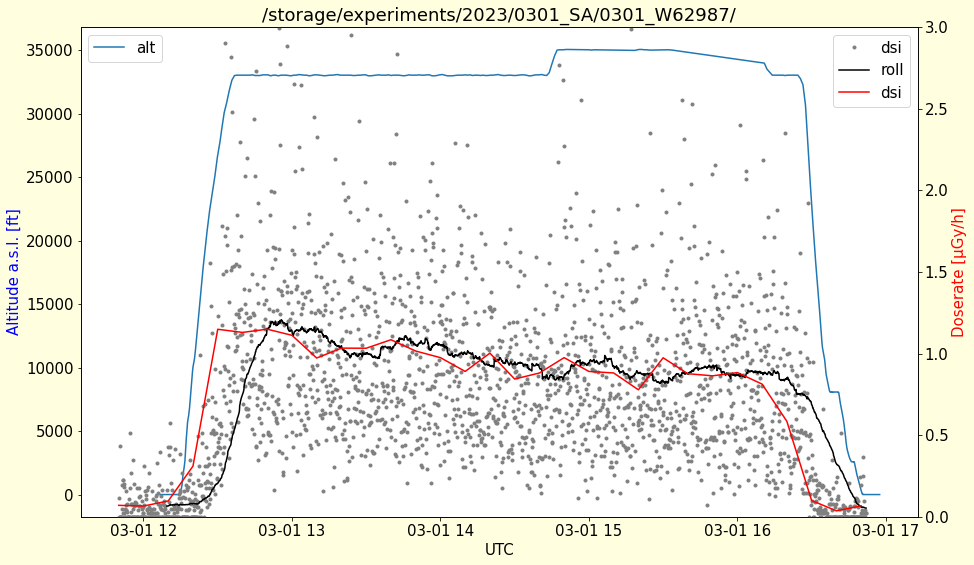

In [26]:
FIRST_CHANNEL = 8

plt.figure(figsize=(15,10), facecolor='lightyellow')
matplotlib.rcParams.update({'font.size': 15})


plt.plot(tele['Altitude'], label='alt')
# Set limits of plot for magnification
#plt.xlim(pd.Timestamp('2019-09-03'),pd.Timestamp('2019-09-7'))
#plt.xlim(pd.Timestamp('2021-06-8'),pd.Timestamp('2021-06-12'))
#plt.xlim(pd.Timestamp('2021-10-8'),pd.Timestamp('2021-11-5')) # SWA last measurement
#plt.xlim(pd.Timestamp('2021-9-15'),pd.Timestamp('2021-9-28')) # SWB last measurement
plt.ylabel('Altitude a.s.l. [ft]', color='blue')
plt.xlabel('UTC')

#rc = rc.iloc[3286:]
plt.legend(loc=2)

plt.twinx()

rc['sum'] = rc[range(FIRST_CHANNEL,500)].sum(axis=1)/6.88/2
#rc['sum'] = rc[range(FIRST_CHANNEL,500)].sum(axis=1)
rc['ener'] = (np.asarray(rc.iloc[:,8:500]) * np.asarray(e3.loc[8:499,'x'])).sum(axis=1)    
rc['dsi'] = ((1e6 * (1.602e-19 * rc['ener'] * 1e6)/0.1398e-3)/6.88) * 3600 #* 2.45 * 1.048#* 1.1 #1.094#2.71 # in uGy/h


rc['dsi'].plot(marker='.', linestyle='', color='gray')
rc['roll'] = rc['dsi'].rolling(150).mean()
rc['roll'].plot(color='black')
rcc = rc.resample('10T').mean()
rcc['dsi'].plot(color='red')
plt.ylabel('Doserate [µGy/h]', color='red')
plt.title(fto)
#plt.yscale('log')

plt.ylim([0,3]) 
plt.legend(loc=1)


/tmp/ipykernel_7839/1754771637.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rcc['sum'] = rcc[range(FIRST_CHANNEL,500)].sum(axis=1)/6.88/2


Text(0, 0.5, 'Flux [s$^-$$^1$ cm$^-$$^2$]')

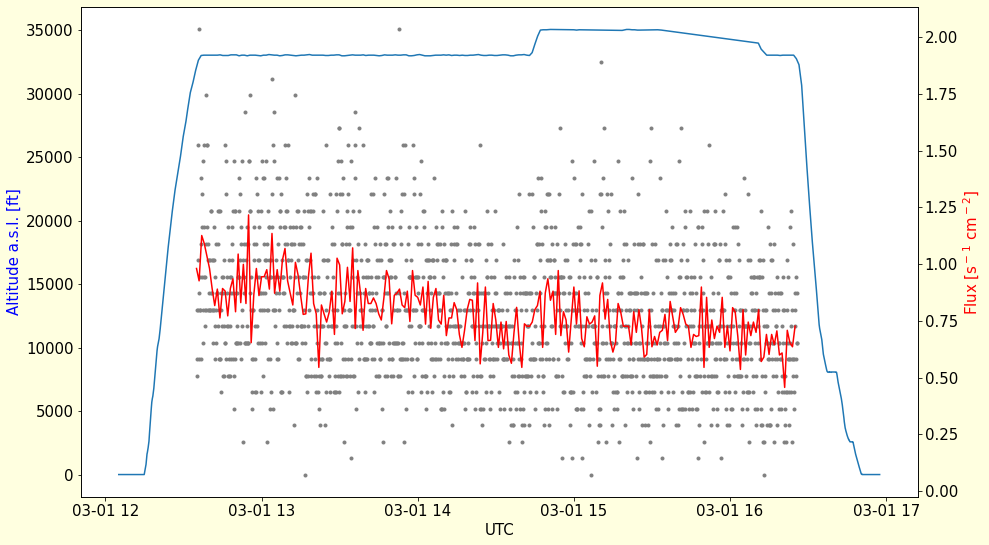

In [32]:
FIRST_CHANNEL = 8

plt.figure(figsize=(15,10), facecolor='lightyellow')
matplotlib.rcParams.update({'font.size': 15})


plt.plot(tele['Altitude'])
# Set limits of plot for magnification
#plt.xlim(pd.Timestamp('2019-09-03'),pd.Timestamp('2019-09-7'))
#plt.xlim(pd.Timestamp('2021-06-8'),pd.Timestamp('2021-06-12'))
#plt.xlim(pd.Timestamp('2021-10-8'),pd.Timestamp('2021-11-5')) # SWA last measurement
#plt.xlim(pd.Timestamp('2021-9-15'),pd.Timestamp('2021-9-28')) # SWB last measurement
plt.ylabel('Altitude a.s.l. [ft]', color='blue')
plt.xlabel('UTC')

rcc = rc.loc['2023-03-1 12:35':'2023-03-1 16:25']

plt.twinx()

rcc['sum'] = rcc[range(FIRST_CHANNEL,500)].sum(axis=1)/6.88/2
#rc['sum'] = rc[range(FIRST_CHANNEL,500)].sum(axis=1)

rcc['sum'].plot(marker='.', linestyle='', color='gray')
rccc = rcc.resample('1T').mean()
rccc['sum'].plot(color='red')
plt.ylabel('Flux [s$^-$$^1$ cm$^-$$^2$]', color='red')

#plt.ylim([0,30]) 


0.034 0.016


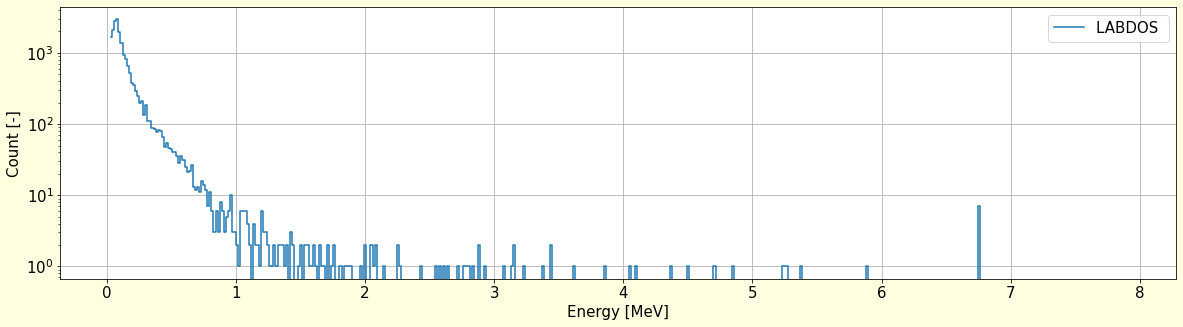

In [13]:
ener = rcc.iloc[:,FIRST_CHANNEL:500].sum()

coef3 = np.array([0.,0.])
coef3[1] = 0.016
coef3[0] = 0.034
#coef3[1] = 0.03
#coef3[0] = 0.06

#(60 keV +-15 keV) + CH * 30 keV 
#0.034 MeV + ch * 0.016 MeV


print (coef3[0], coef3[1])

e3 = pd.DataFrame()
e3['1'] = ener
e3['i'] = ener.index
e3['x'] = (e3['i'].astype(float)-FIRST_CHANNEL) * coef3[1] + coef3[0]

plt.figure(figsize=(20,5), facecolor='lightyellow')
matplotlib.rcParams.update({'font.size': 15})
plt.yscale('log')
#plt.xscale('log')

plt.plot(e3['x'], e3['1'] , label='LABDOS ', drawstyle='steps-mid')

plt.xlabel('Energy [MeV]')
plt.ylabel('Count [-]')
plt.grid()
plt.legend()
#plt.xticks(np.arange(0, 10, 1))
#plt.xlim(0,2)
#plt.vlines(0.511,1,1e4, color='red')

None

0.034 0.016


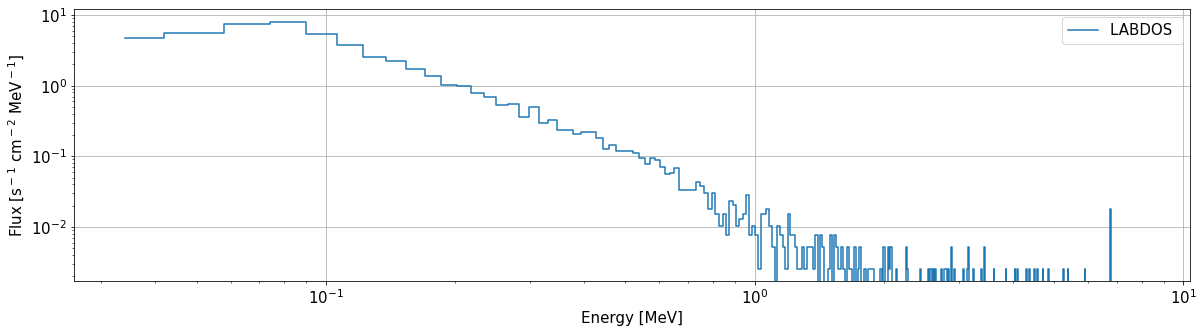

In [36]:
ener = rc.iloc[:,FIRST_CHANNEL:500].sum()

coef3 = np.array([0.,0.])
coef3[1] = 0.016
coef3[0] = 0.034
#coef3[1] = 0.03
#coef3[0] = 0.06

#(60 keV +-15 keV) + CH * 30 keV 
#0.034 MeV + ch * 0.016 MeV


print (coef3[0], coef3[1])

e3 = pd.DataFrame()
e3['1'] = ener
e3['i'] = ener.index
e3['x'] = (e3['i'].astype(float)-FIRST_CHANNEL) * coef3[1] + coef3[0] 
plt.figure(figsize=(20,5))
matplotlib.rcParams.update({'font.size': 15})
plt.yscale('log')
plt.xscale('log')

plt.plot(e3['x'], e3['1'] / 2 / measurement_duration / coef3[1], label='LABDOS ', drawstyle='steps-mid')

plt.xlabel('Energy [MeV]')
plt.ylabel('Flux [s$^-$$^1$ cm$^-$$^2$ MeV$^-$$^1$]')
plt.grid()
plt.legend()
#plt.xticks(np.arange(0, 10, 1))
#plt.xlim(0,2)
#plt.vlines(0.511,1,1e4, color='red')

None

In [33]:
print('The first measurement', rcc.iloc[0,1])
print('The last measurement', rcc.iloc[-1,1])
measurement_duration = (int(rcc.iloc[-1,1]) - int(rcc.iloc[0,1])) * 6.88
flight_duration = rcc.iloc[-1,2] - rcc.iloc[0,2]
print('Begin', rcc.iloc[0,2], 's')
print('End', rcc.iloc[-1,2], 's')
print('Flight duration', round(flight_duration,2), 's')
print('Measurement duration', measurement_duration, 's')
deathtime_ratio = flight_duration / measurement_duration
print('Deathtime ratio', round(deathtime_ratio,2))

e3['total'] = e3['1']*e3['x']
depener = e3['total'].sum()*deathtime_ratio
print('Deposited Energy including deathtime', round(depener,2), 'MeV')
dose = (1e6*(1.602e-19 * depener*1e6)/0.1398e-3) 

# size of the chip (20 mm · 10 mm), 
# the thickness of the depletion layer (0.3 mm), 
# and the density of silicon (2.33 g cm^3)
# 0.1398e-3 kg
#dose = ((1e6 * (1.602e-19 * depener * 1e6)/0.1398e-3)/10.4) * 3600 * 2.71 # in uGy/h

print('Dose in silicon', round(dose,2), 'µGy')


The first measurement 346
The last measurement 2125
Begin 2700.27 s
End 16554.1 s
Flight duration 13853.83 s
Measurement duration 12239.52 s
Deathtime ratio 1.13
Deposited Energy including deathtime 3416.34 MeV
Dose in silicon 3.91 µGy


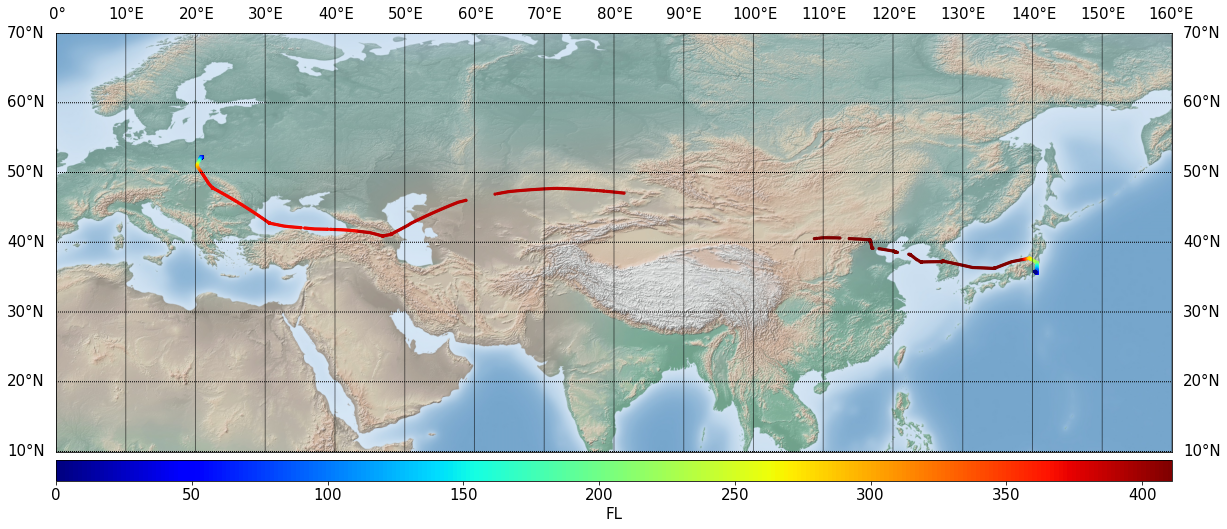

In [83]:
import time, calendar, datetime, numpy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib
import urllib, os

tele['lat'] = tele['Position'].str.split(',').str[0]
tele['lon'] = tele['Position'].str.split(',').str[1]
tele.lon = pd.to_numeric(tele.lon)
tele.lat = pd.to_numeric(tele.lat)
tele.Altitude = pd.to_numeric(tele.Altitude)


plt.figure(figsize=(20,20))
plt.tight_layout()

matplotlib.rcParams.update({'font.size': 15})

# create Basemap instance.
#m = Basemap(projection='kav7',lon_0=0)
m = Basemap(projection='cyl',lon_0=0, llcrnrlon=0,llcrnrlat=10,urcrnrlon=160,urcrnrlat=70)
#m = Basemap(projection='robin',lon_0=0)
#m = Basemap(llcrnrlon=-180,llcrnrlat=-80,urcrnrlon=180,urcrnrlat=85,projection='mill')


x, y = m(tele.lon.tolist(),tele.lat.tolist())
#m.drawmapboundary(fill_color='#99ffff')
#m.fillcontinents(color='#cc9966',lake_color='#99ffff',zorder=0)
# draw parallels and meridians, but don't bother labelling them.
m.drawparallels(np.arange(-90.,+90.,10.),labels=[1,1,0,0])
m.drawmeridians(np.arange(-180.,180.,10.),labels=[0,0,1,0])
m.shadedrelief()

im1 = m.scatter(x,y,c=(tele.Altitude/100).tolist(),marker='.', s = 20, cmap='jet')
cb = m.colorbar(im1,"bottom", size="5%", pad="2%")
cb.set_label('FL')

#plt.clim(0, 12500)  # limit for color axis
plt.show()                


In [38]:
cari_photons = pd.read_csv('/storage/experiments/2023/0301_SA/0301_W62987/CARI/W62987_2f5ddba8_D_photons.DAT', delim_whitespace=True, skipfooter=3, skiprows=1, header=None, comment='*', engine='python')
cari_photons.reset_index(drop=True, inplace=True)
cari_photons['time'] = pd.to_datetime(dict(year=cari_photons[6], month=cari_photons[7], day=cari_photons[8], hour=cari_photons[9], minute=cari_photons[10]))
cari_photons.set_index('time', drop=False, inplace=True)
print('Loaded')

Loaded


In [39]:
cari_electrons = pd.read_csv('/storage/experiments/2023/0301_SA/0301_W62987/CARI/W62987_2f5ddba8_D_electrons.DAT', delim_whitespace=True, skipfooter=3, skiprows=1, header=None, comment='*', engine='python')
cari_electrons.reset_index(drop=True, inplace=True)
cari_electrons['time'] = pd.to_datetime(dict(year=cari_electrons[6], month=cari_electrons[7], day=cari_electrons[8], hour=cari_electrons[9], minute=cari_electrons[10]))
cari_electrons.set_index('time', drop=False, inplace=True)
print('Loaded')

Loaded


In [46]:
cari_protons = pd.read_csv('/storage/experiments/2023/0301_SA/0301_W62987/CARI/W62987_2f5ddba8_D_protons.DAT', delim_whitespace=True, skipfooter=3, skiprows=1, header=None, comment='*', engine='python')
cari_protons.reset_index(drop=True, inplace=True)
cari_protons['time'] = pd.to_datetime(dict(year=cari_protons[6], month=cari_protons[7], day=cari_protons[8], hour=cari_protons[9], minute=cari_protons[10]))
cari_protons.set_index('time', drop=False, inplace=True)
print('Loaded')

Loaded


In [58]:
cari_alphas = pd.read_csv('/storage/experiments/2023/0301_SA/0301_W62987/CARI/W62987_2f5ddba8_D_alphas.DAT', delim_whitespace=True, skipfooter=3, skiprows=1, header=None, comment='*', engine='python')
cari_alphas.reset_index(drop=True, inplace=True)
cari_alphas['time'] = pd.to_datetime(dict(year=cari_alphas[6], month=cari_alphas[7], day=cari_alphas[8], hour=cari_alphas[9], minute=cari_alphas[10]))
cari_alphas.set_index('time', drop=False, inplace=True)
print('Loaded')

Loaded


In [54]:
cari_neg_muons = pd.read_csv('/storage/experiments/2023/0301_SA/0301_W62987/CARI/W62987_2f5ddba8_D_neg_muons.DAT', delim_whitespace=True, skipfooter=3, skiprows=1, header=None, comment='*', engine='python')
cari_neg_muons.reset_index(drop=True, inplace=True)
cari_neg_muons['time'] = pd.to_datetime(dict(year=cari_neg_muons[6], month=cari_neg_muons[7], day=cari_neg_muons[8], hour=cari_neg_muons[9], minute=cari_neg_muons[10]))
cari_neg_muons.set_index('time', drop=False, inplace=True)
print('Loaded')

Loaded


In [118]:
cari_positrons = pd.read_csv('/storage/experiments/2023/0301_SA/0301_W62987/CARI/W62987_2f5ddba8_D_positrons.DAT', delim_whitespace=True, skipfooter=3, skiprows=1, header=None, comment='*', engine='python')
cari_positrons.reset_index(drop=True, inplace=True)
cari_positrons['time'] = pd.to_datetime(dict(year=cari_positrons[6], month=cari_positrons[7], day=cari_positrons[8], hour=cari_positrons[9], minute=cari_positrons[10]))
cari_positrons.set_index('time', drop=False, inplace=True)
print('Loaded')

Loaded


In [49]:
cari_total = pd.read_csv('/storage/experiments/2023/0301_SA/0301_W62987/CARI/W62987_2f5ddba8_D_Total.DAT', delim_whitespace=True, skipfooter=3, skiprows=1, header=None, comment='*', engine='python')
cari_total.reset_index(drop=True, inplace=True)
cari_total['time'] = pd.to_datetime(dict(year=cari_total[6], month=cari_total[7], day=cari_total[8], hour=cari_total[9], minute=cari_total[10]))
cari_total.set_index('time', drop=False, inplace=True)
print('Loaded')

Loaded


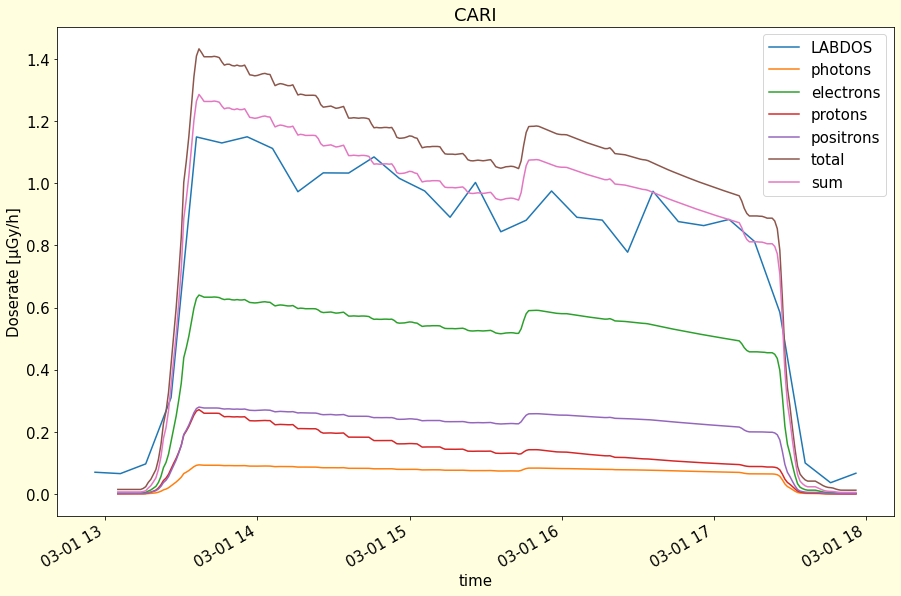

In [192]:
plt.figure(figsize=(15,10), facecolor='lightyellow')
matplotlib.rcParams.update({'font.size': 15})

plt.plot(rcc.index + timedelta(hours=1.1),rcc['dsi'], label='LABDOS')
#plt.plot(rc.index + timedelta(hours=1),rc['roll'], label='LABDOS')

cari_photons[4].plot(label='photons')
cari_electrons[4].plot(label='electrons')
cari_protons[4].plot(label='protons')
#cari_alphas[4].plot(label='alphas')
cari_positrons[4].plot(label='positrons')
#cari_neg_muons[4].plot(label='neg_muons')
cari_total[4].plot(label='total')
(cari_photons[4]+cari_electrons[4]+cari_protons[4]+cari_positrons[4]).plot(label='sum')
plt.ylabel('Doserate [µGy/h]')
plt.title('CARI')
plt.legend()

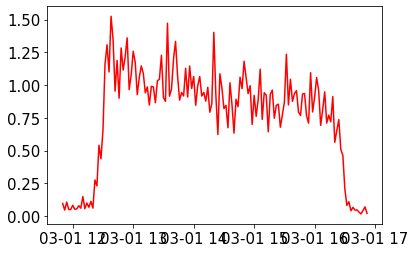

In [145]:
plt.plot(rcc.index,rcc['dsi'], color='red')


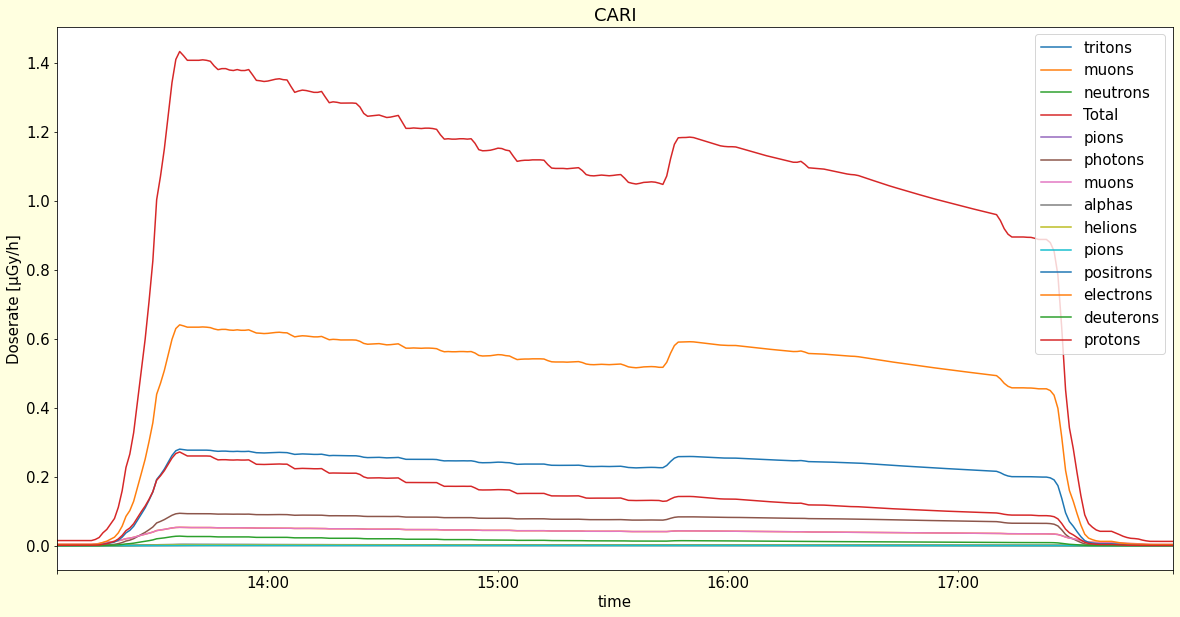

In [151]:
plt.figure(figsize=(20,10), facecolor='lightyellow')
matplotlib.rcParams.update({'font.size': 15})


dto = '/storage/experiments/2023/0301_SA/0301_W62987/CARI/'


for fto in glob.iglob(dto + 'W62987_2f5ddba8_D*'): # generator, search immediate subdirectories 
    particles = fto.split('/')[-1].split('.')[-2].split('_')[-1]
    if (len(particles)>2):
        cari = pd.read_table(fto, delim_whitespace=True, skipfooter=3, skiprows=1, header=None, comment='*', engine='python')    
        #cari.reset_index(drop=True, inplace=True)
        cari['time'] = pd.to_datetime(dict(year=cari[6], month=cari[7], day=cari[8], hour=cari[9], minute=cari[10]))
        cari.set_index('time', drop=False, inplace=True)
        cari[4].plot(label=particles)
    

plt.ylabel('Doserate [µGy/h]')
plt.title('CARI')
plt.legend()

In [113]:
fto.split('/')[-1].split('.')[-2].split('_')[-1]

'tritons'

# Load and plot mutiple devices

/storage/experiments/2023/04_HIMAC/WAW_NRT/LABDOS_D9/0.TXT
/storage/experiments/2023/04_HIMAC/WAW_NRT/LABDOS_EF/0.TXT
/storage/experiments/2023/04_HIMAC/WAW_NRT/LABDOS_7E/0.TXT
/storage/experiments/2023/04_HIMAC/WAW_NRT/LABDOS_8B/0.TXT
/storage/experiments/2023/04_HIMAC/WAW_NRT/LABDOS_4E/0.TXT
/storage/experiments/2023/04_HIMAC/WAW_NRT/LABDOS_B8/0.TXT
/storage/experiments/2023/04_HIMAC/WAW_NRT/LABDOS_20/0.TXT


Text(0, 0.5, 'Altitude a.s.l. [ft]')

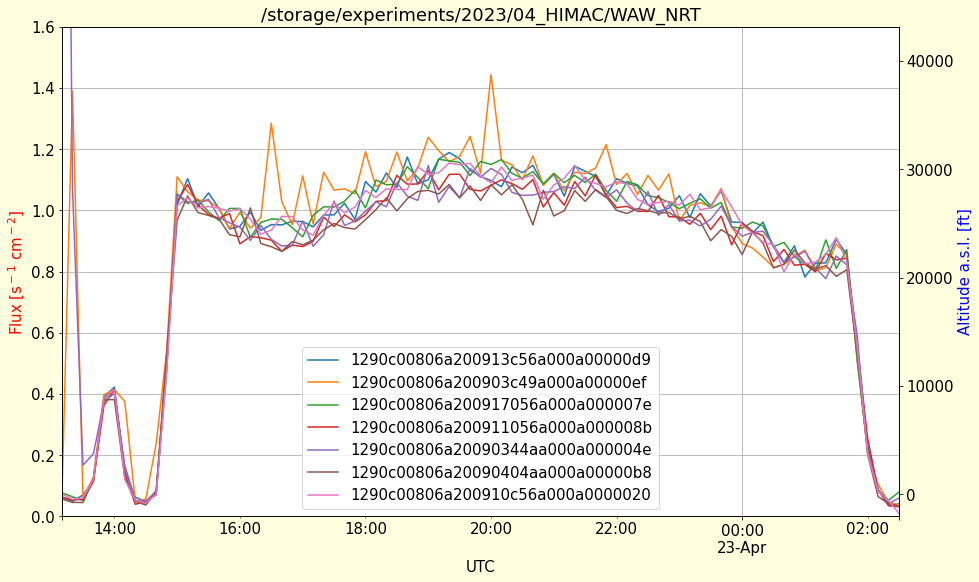

In [115]:
ftt = glob.iglob(fto+"/**/*.TXT") # generator, search immediate subdirectories 
SWITCH_ON_TIMES = ['2023-04-22 13:15']

plt.figure(figsize=(15,10), facecolor='lightyellow')
matplotlib.rcParams.update({'font.size': 15})

for f in ftt:
    l=[]
    l.extend(range(0,505))

    df = pd.read_csv(f, sep=',', header=None, names=l, comment='*', low_memory=False)
    df = df.reset_index(drop=True)
    print(f)
    
    df[2] = df[2].apply(pd.to_numeric, errors='coerce')

    df['runtime'] = np.nan
    df.loc[df[0]=='$HIST','seconds'] = df.loc[df[0]=='$HIST',2]
    df.loc[df[0]=='$DOS','seconds'] = 0
    df['runtime'] = df['seconds'].diff() * -1
    rc = df.copy()

    run = 0
    rc['run'] = np.nan

    try:
        for x in rc.loc[rc[0]=='$DOS'].index:
            rc.loc[x,'run'] = SWITCH_ON_TIMES[run]
            run += 1
    except:
        pass
    rc['run'].fillna(method="ffill", inplace=True)

    rc[2] = pd.to_numeric(rc[2])
    rc['time'] = pd.to_datetime(rc.run) + pd.to_timedelta(rc[2], unit='s')
    rc.set_index(rc['time'], drop=False, inplace=True)
    
    FIRST_CHANNEL = 9

    rc['sum'] = rc[range(FIRST_CHANNEL,500)].sum(axis=1)/10/2

    #rc['sum'].plot(marker='.', linestyle='', color='gray')
    rcc = rc.resample('10T').mean()
    rcc['sum'].plot(label=str(rc.loc[rc[0]=='$DOS'][[6]].iloc[0,0]))

    plt.ylim([0,1.6]) 

plt.ylabel('Flux [s$^-$$^1$ cm$^-$$^2$]', color='red')
plt.title(fto)
plt.legend()
plt.grid()
plt.xlabel('UTC')
  
plt.twinx()

tele['Altitude'].plot(label='Altitude')
plt.ylabel('Altitude a.s.l. [ft]', color='blue')


/storage/experiments/2023/04_HIMAC/WAW_NRT/LABDOS_D9/0.TXT
0.034 0.016
/storage/experiments/2023/04_HIMAC/WAW_NRT/LABDOS_EF/0.TXT
0.034 0.016
/storage/experiments/2023/04_HIMAC/WAW_NRT/LABDOS_7E/0.TXT
0.034 0.016
/storage/experiments/2023/04_HIMAC/WAW_NRT/LABDOS_8B/0.TXT
0.034 0.016
/storage/experiments/2023/04_HIMAC/WAW_NRT/LABDOS_4E/0.TXT
0.034 0.016
/storage/experiments/2023/04_HIMAC/WAW_NRT/LABDOS_B8/0.TXT
0.034 0.016
/storage/experiments/2023/04_HIMAC/WAW_NRT/LABDOS_20/0.TXT
0.034 0.016


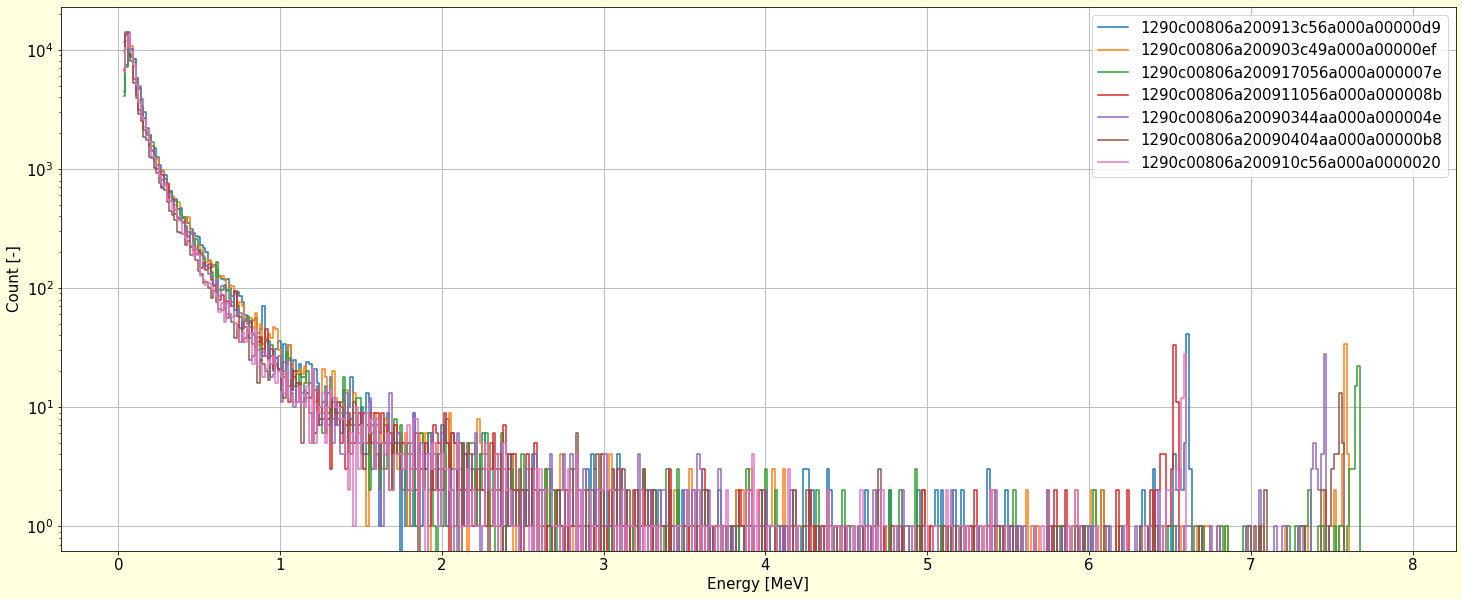

In [150]:
ftt = glob.iglob(fto+"/**/*.TXT") # generator, search immediate subdirectories 
SWITCH_ON_TIMES = ['2023-04-22 13:15']

plt.figure(figsize=(25,10), facecolor='lightyellow')
matplotlib.rcParams.update({'font.size': 15})

for f in ftt:
    l=[]
    l.extend(range(0,505))

    df = pd.read_csv(f, sep=',', header=None, names=l, comment='*', low_memory=False)
    df = df.reset_index(drop=True)
    print(f)
    
    df[2] = df[2].apply(pd.to_numeric, errors='coerce')

    df['runtime'] = np.nan
    df.loc[df[0]=='$HIST','seconds'] = df.loc[df[0]=='$HIST',2]
    df.loc[df[0]=='$DOS','seconds'] = 0
    df['runtime'] = df['seconds'].diff() * -1
    rc = df.copy()

    run = 0
    rc['run'] = np.nan

    try:
        for x in rc.loc[rc[0]=='$DOS'].index:
            rc.loc[x,'run'] = SWITCH_ON_TIMES[run]
            run += 1
    except:
        pass
    rc['run'].fillna(method="ffill", inplace=True)

    rc[2] = pd.to_numeric(rc[2])
    rc['time'] = pd.to_datetime(rc.run) + pd.to_timedelta(rc[2], unit='s')
    rc.set_index(rc['time'], drop=False, inplace=True)
    
    FIRST_CHANNEL = 9

    ener = rc.iloc[:,FIRST_CHANNEL:500].sum()

    coef3 = np.array([0.,0.])
    coef3[1] = 0.016
    coef3[0] = 0.034
    #0.034 MeV + ch * 0.016 MeV

    print (coef3[0], coef3[1])

    e3 = pd.DataFrame()
    e3['1'] = ener
    e3['i'] = ener.index
    e3['x'] = (e3['i'].astype(float)-FIRST_CHANNEL) * coef3[1] + coef3[0]

    plt.yscale('log')
    #plt.xscale('log')

    plt.plot(e3['x'], e3['1'] , label=str(rc.loc[rc[0]=='$DOS'][[6]].iloc[0,0]), drawstyle='steps-mid')

plt.xlabel('Energy [MeV]')
plt.ylabel('Count [-]')
plt.grid()
plt.legend()


#plt.xticks(np.arange(0, 10, 1))
#plt.xlim(0,2)
#plt.vlines(0.511,1,1e4, color='red')

None

/storage/experiments/2023/04_HIMAC/WAW_NRT/LABDOS_D9/0.TXT
0.034 0.016
/storage/experiments/2023/04_HIMAC/WAW_NRT/LABDOS_EF/0.TXT
0.034 0.016
/storage/experiments/2023/04_HIMAC/WAW_NRT/LABDOS_7E/0.TXT
0.034 0.016
/storage/experiments/2023/04_HIMAC/WAW_NRT/LABDOS_8B/0.TXT
0.034 0.016
/storage/experiments/2023/04_HIMAC/WAW_NRT/LABDOS_4E/0.TXT
0.034 0.016
/storage/experiments/2023/04_HIMAC/WAW_NRT/LABDOS_B8/0.TXT
0.034 0.016
/storage/experiments/2023/04_HIMAC/WAW_NRT/LABDOS_20/0.TXT
0.034 0.016


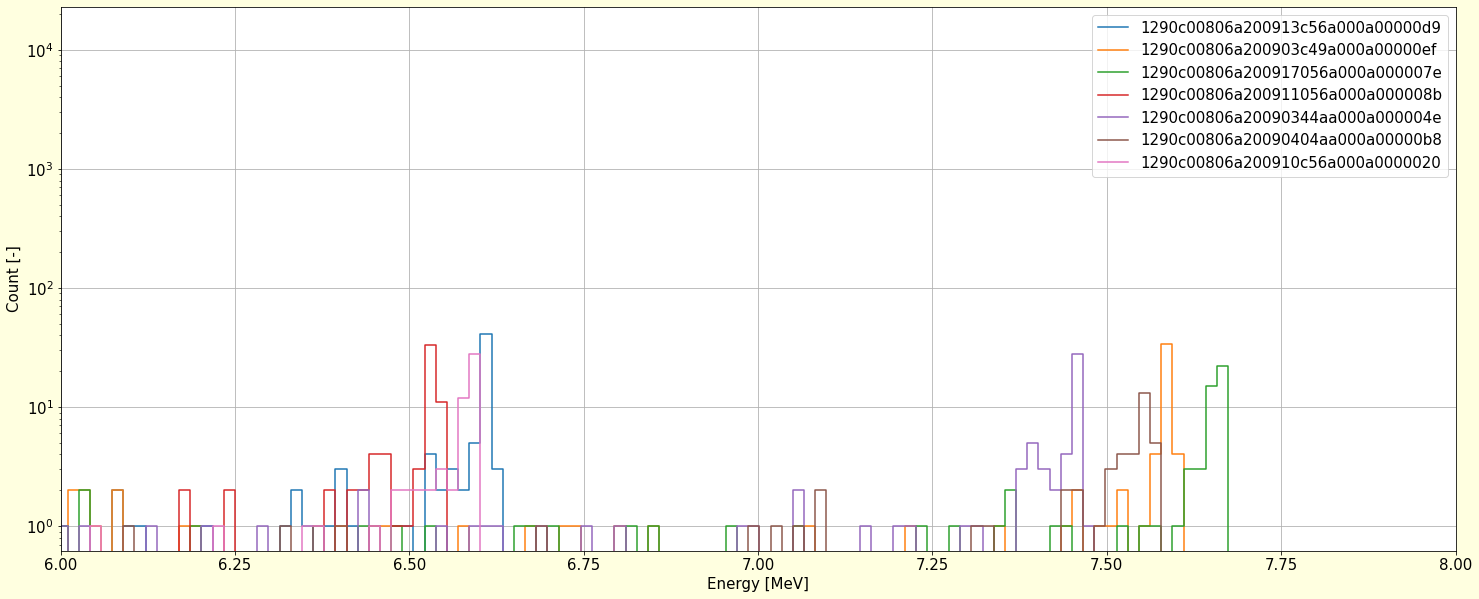

In [152]:
ftt = glob.iglob(fto+"/**/*.TXT") # generator, search immediate subdirectories 
SWITCH_ON_TIMES = ['2023-04-22 13:15']

plt.figure(figsize=(25,10), facecolor='lightyellow')
matplotlib.rcParams.update({'font.size': 15})

for f in ftt:
    l=[]
    l.extend(range(0,505))

    df = pd.read_csv(f, sep=',', header=None, names=l, comment='*', low_memory=False)
    df = df.reset_index(drop=True)
    print(f)
    
    df[2] = df[2].apply(pd.to_numeric, errors='coerce')

    df['runtime'] = np.nan
    df.loc[df[0]=='$HIST','seconds'] = df.loc[df[0]=='$HIST',2]
    df.loc[df[0]=='$DOS','seconds'] = 0
    df['runtime'] = df['seconds'].diff() * -1
    rc = df.copy()

    run = 0
    rc['run'] = np.nan

    try:
        for x in rc.loc[rc[0]=='$DOS'].index:
            rc.loc[x,'run'] = SWITCH_ON_TIMES[run]
            run += 1
    except:
        pass
    rc['run'].fillna(method="ffill", inplace=True)

    rc[2] = pd.to_numeric(rc[2])
    rc['time'] = pd.to_datetime(rc.run) + pd.to_timedelta(rc[2], unit='s')
    rc.set_index(rc['time'], drop=False, inplace=True)
    
    FIRST_CHANNEL = 9

    ener = rc.iloc[:,FIRST_CHANNEL:500].sum()

    coef3 = np.array([0.,0.])
    coef3[1] = 0.016
    coef3[0] = 0.034
    #0.034 MeV + ch * 0.016 MeV

    print (coef3[0], coef3[1])

    e3 = pd.DataFrame()
    e3['1'] = ener
    e3['i'] = ener.index
    e3['x'] = (e3['i'].astype(float)-FIRST_CHANNEL) * coef3[1] + coef3[0]

    plt.yscale('log')
    #plt.xscale('log')

    plt.plot(e3['x'], e3['1'] , label=str(rc.loc[rc[0]=='$DOS'][[6]].iloc[0,0]), drawstyle='steps-mid')

plt.xlabel('Energy [MeV]')
plt.ylabel('Count [-]')
plt.grid()
plt.legend()


#plt.xticks(np.arange(0, 10, 1))
plt.xlim(6,8)
#plt.vlines(0.511,1,1e4, color='red')

None

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(0.0, 20.0)

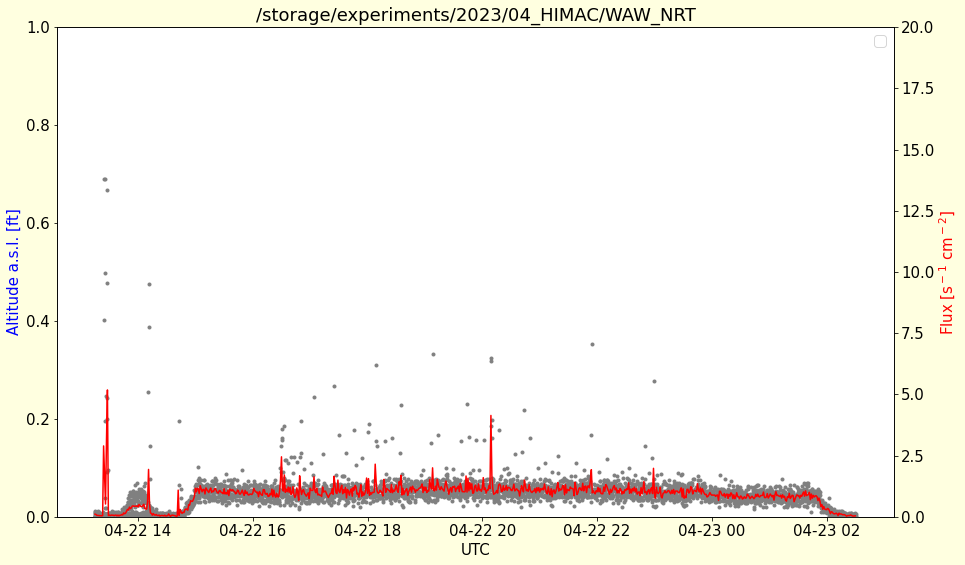

In [135]:
FIRST_CHANNEL = 9

plt.figure(figsize=(15,10), facecolor='lightyellow')
matplotlib.rcParams.update({'font.size': 15})


#plt.plot(tele['Altitude'], label=str(rc.loc[rc[0]=='$DOS'][[6]].iloc[0,0]))
# Set limits of plot for magnification
#plt.xlim(pd.Timestamp('2019-09-03'),pd.Timestamp('2019-09-7'))
#plt.xlim(pd.Timestamp('2021-06-8'),pd.Timestamp('2021-06-12'))
#plt.xlim(pd.Timestamp('2021-10-8'),pd.Timestamp('2021-11-5')) # SWA last measurement
#plt.xlim(pd.Timestamp('2021-9-15'),pd.Timestamp('2021-9-28')) # SWB last measurement
plt.ylabel('Altitude a.s.l. [ft]', color='blue')
plt.xlabel('UTC')
plt.legend()
#rc = rc.iloc[3286:]

plt.twinx()

rc['sum'] = rc[range(FIRST_CHANNEL,500)].sum(axis=1)/10/2
#rc['sum'] = rc[range(FIRST_CHANNEL,500)].sum(axis=1)

rc['sum'].plot(marker='.', linestyle='', color='gray')
rcc = rc.resample('1T').mean()
rcc['sum'].plot(color='red')
plt.ylabel('Flux [s$^-$$^1$ cm$^-$$^2$]', color='red')
plt.title(fto)

plt.ylim([0,20]) 


In [147]:
pd.set_option('display.max_columns', 40)
pd.set_option('display.max_rows', 400)

rc.loc['2023-04-22 20:40':'2023-04-22 20:50'].iloc[:,8:40]


/tmp/ipykernel_5202/556692503.py:4: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  rc.loc['2023-04-22 20:40':'2023-04-22 20:50'].iloc[:,8:40]


,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-04-22 20:40:03.620,8.0,2.0,4.0,5.0,1.0,2.0,1.0,2.0,1.0,2.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-04-22 20:40:14.420,9.0,0.0,2.0,3.0,2.0,1.0,3.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-04-22 20:40:25.240,5.0,1.0,10.0,1.0,5.0,3.0,3.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-04-22 20:40:36.500,3.0,0.0,3.0,9.0,4.0,3.0,3.0,2.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2023-04-22 20:40:47.160,6.0,1.0,2.0,0.0,3.0,3.0,1.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-04-22 20:40:57.980,5.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-04-22 20:41:09.800,10.0,2.0,2.0,4.0,3.0,0.0,3.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-04-22 20:41:19.890,6.0,1.0,0.0,4.0,2.0,2.0,0.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-04-22 20:41:31.000,5.0,0.0,3.0,2.0,2.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
